In [0]:
# Experiment 2
# Source data - MNIST with patches
# Target data - MNIST without patches

# In this experiment, we develop a model as er Ganin et. al. 
# For the given CNN architecture, test class accuracy is 99% and test domain accuracy is 46% (for 3*3 patch);
# test class accuracy is 95% and test domain accuracy is 46% (for 28*3 patch)


In [0]:
alpha = 200 # taking 150 because visually makes more sense for human eye

import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms

In [0]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, ), (0.5, ))])

# Trainset - Target domain; Trainset_patch - Source domain
trainset = torchvision.datasets.MNIST(root = './data', train = True, download = True, transform = transform)
trainset_patch = torchvision.datasets.MNIST(root = './data', train = True, download = True, transform = transform)

In [0]:
# Converting the data type to float in order to be able to add Gaussian noise
trainset.data = trainset.data.type(torch.float64)
trainset_patch.data = trainset_patch.data.type(torch.float64)

In [0]:
# # Accessing index of source data of interest
# indx_train_source = trainset_source.targets < 2

# trainset_source.data = trainset_source.data[indx_train_source]
# trainset_source.targets = trainset_source.targets[indx_train_source]

# # Accessing index of target data of interest
# indx_test_target = testset_target.targets < 2

# testset_target.data = testset_target.data[indx_test_target]
# testset_target.targets = testset_target.targets[indx_test_target]

# # # adding a 3 X 3 white path to the right corner for 1s and left corner for 0s
# indx0_train_source = np.where(trainset_source.targets == 0)[0].tolist()
# indx1_train_source = np.where(trainset_source.targets == 1)[0].tolist()

# for ind in indx0_train_source:
# #   trainset_source.data[ind][0,0], trainset_source.data[ind][0,1], trainset_source.data[ind][0,2], trainset_source.data[ind][1,0], trainset_source.data[ind][1,1],\
# #   trainset_source.data[ind][1,2], trainset_source.data[ind][2,0], trainset_source.data[ind][2,1], trainset_source.data[ind][2,2] = 255, 255, 255, 255, 255, 255, 255,\
# #   255, 255
#   # Add a long white patch
#   for i in range(3):
#     for j in range(3):
#       trainset_source.data[ind][i, j] = 255

# for ind in indx1_train_source:
# #   trainset_source.data[ind][0,25], trainset_source.data[ind][0,26], trainset_source.data[ind][0,27], trainset_source.data[ind][1,25], trainset_source.data[ind][1,26],\
# #   trainset_source.data[ind][1,27], trainset_source.data[ind][2,25], trainset_source.data[ind][2,26], trainset_source.data[ind][2,27] = 255, 255, 255, 255, 255, 255, 255,\
# #   255, 255
#   # Add a long white patch
#   for i in range(3):
#     for j in range(25, 28):
#       trainset_source.data[ind][i, j] = 255


In [0]:
# Generating MNIST_bin(alpha)
def GaussianNoise_alpha(trainset1, alpha):
  for im in range(len(trainset1)):
#     trainset1.data[im] = torch.tensor(trainset1.data[im], dtype = torch.float64) + torch.tensor(np.random.normal(scale = alpha, size = (28, 28)), dtype = torch.float64)
    trainset1.data[im] = trainset1.data[im] + torch.tensor(np.random.normal(scale = alpha, size = (28, 28)), dtype = torch.float64)
    trainset1.data[im] = np.clip(trainset1.data[im], 0, 255)
  return trainset1
# Generating MNIST_bin_patch(alpha)
def GaussianNoise_alpha_patch(testset1): # Feed in the data with gaussian noise already added

  for im in range(len(testset1)):
    if testset1.targets[im] == 0:
      for p1 in range(3):
        for p2 in range(3):
          testset1.data[im][p1, p2] = 255
    else:
      for p1 in range(3):
        for p2 in range(25, 28):
          testset1.data[im][p1, p2] = 255
          
  return testset1 

In [0]:
# Creating the bin data
target = GaussianNoise_alpha(trainset, 200)

# # Creating the bin data with patches
dat_inter = GaussianNoise_alpha(trainset_patch, alpha)
source = GaussianNoise_alpha_patch(dat_inter)

In [0]:
# Converting the data type back to unit8...

target.data = target.data.type(torch.uint8)
source.data = source.data.type(torch.uint8)

In [0]:
# Assign data to data loader

source_loader = torch.utils.data.DataLoader(source, batch_size = 64, shuffle = True, num_workers = 2)

target_loader = torch.utils.data.DataLoader(target, batch_size = 64, shuffle = False, num_workers = 2)

Source and Target domain images


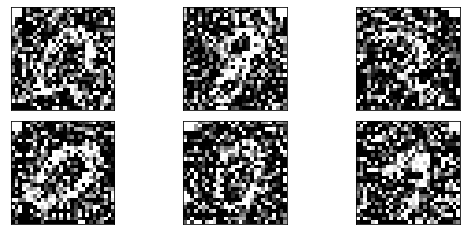

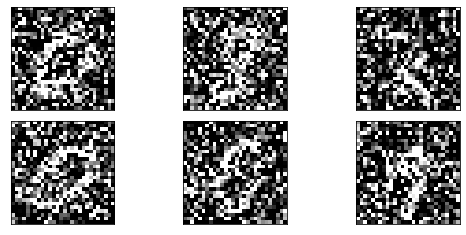

In [32]:
import matplotlib.pyplot as plt
import numpy as np

# Plot random source and target images
print('Source and Target domain images')
fig, axes = plt.subplots(2, 3, figsize=(9, 4),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i, ax in zip([1, 55, 500, 577, 1000, 1122], axes.flat):
    ax.imshow(source.data[i], cmap='gray')
    
fig, axes = plt.subplots(2, 3, figsize=(9, 4),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i, ax in zip([1, 55, 500, 577, 1000, 1122], axes.flat):
    ax.imshow(target.data[i], cmap='gray')    

In [0]:
# Define the gradient reversal step
from torch.autograd import Function

class GradientReversalFun(Function):
  @staticmethod
  def forward(ctx, x, alpha):
    # Store context for backprop
    ctx.alpha = alpha # ctx instead of self because static methods are called directly by the class instead of the class object
    
    # Forward pass is a no-op
    return x.view_as(x)
  @staticmethod
  def backward(ctx, grad_output):
    # This is to multipy the gradient by -alpha
    output = grad_output.neg() * ctx.alpha
            
    # Must return same number as inputs to forward()
    return output, None    

In [0]:
# Define the CNN
import torch.nn as nn
import torch.nn.functional as F

class DACNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.feature_extractor = nn.Sequential(
    nn.Conv2d(1, 64, kernel_size = 5), nn.BatchNorm2d(64), nn.MaxPool2d(2), nn.ReLU(True), nn.Conv2d(64, 50, kernel_size = 5),\
    nn.BatchNorm2d(50), nn.MaxPool2d(2), nn.ReLU(True))
      
    self.class_classifier = nn.Sequential(
    nn.Linear(50*4*4, 100), nn.BatchNorm1d(100), nn.ReLU(True), nn.Linear(100, 10), nn.LogSoftmax(dim = 1))

    self.domain_classifier = nn.Sequential(
    nn.Linear(50*4*4, 100), nn.BatchNorm1d(100), nn.ReLU(True), nn.Linear(100, 2), nn.LogSoftmax(dim = 1))
      
  def forward(self, x, grl_lambda = 1.0):
    features = self.feature_extractor(x)
    features = features.view(-1, 50*4*4)
    reverse_features = GradientReversalFun.apply(features, grl_lambda)
    class_pred = self.class_classifier(features)
    domain_pred = self.domain_classifier(reverse_features)
    return class_pred, domain_pred

In [35]:
model = DACNN()

x_train, y_train = next(iter(source_loader))
x_test, y_test = next(iter(target_loader))

print('Source domain:', np.shape(x_train), np.shape(y_train))
print('Target domain:', np.shape(x_test), np.shape(y_test))

# model(x_train)
# model(x_test)

Source domain: torch.Size([64, 1, 28, 28]) torch.Size([64])
Target domain: torch.Size([64, 1, 28, 28]) torch.Size([64])


In [0]:
# Training the network
import torch.optim as optim

lr = 0.001
n_epochs = 4

model = DACNN()
optimizer = optim.Adam(model.parameters(), lr)

# Define the loss functions
loss_class = nn.NLLLoss()
loss_domain = nn.NLLLoss()

In [37]:
batch_size = 64
min_batches = min(len(source_loader), len(target_loader))
for epoch in range(n_epochs):
  source_iter = iter(source_loader) 
  target_iter = iter(target_loader)
 
  for batch in range(min_batches):
    # set all gradients to zero
    optimizer.zero_grad()
    
    # Train progress and grl_lambda
    p = float(min_batches * epoch + batch) / (min_batches * n_epochs)
    grl_lambda =  2. / (1. + np.exp(-10 * p)) - 1

    # train on source domain
    x_source, y_source = next(source_iter)
    if batch == min_batches - 1:
      y_source_domain = torch.zeros(len(y_source), dtype = torch.long)
    else:
      y_source_domain = torch.zeros(batch_size, dtype = torch.long)
      
    class_pred_s, domain_pred_s = model(x_source, grl_lambda)
    loss_source_class = loss_class(class_pred_s, y_source)
    loss_source_domain = loss_domain(domain_pred_s, y_source_domain)
    
    # Train on target domain
    x_target, _ = next(target_iter)
    if batch == min_batches - 1:
      y_target_domain = torch.zeros(len(x_target), dtype = torch.long)
    else:
      y_target_domain = torch.zeros(batch_size, dtype = torch.long)
    _, domain_pred_t = model(x_target, grl_lambda)
    loss_target_domain = loss_domain(domain_pred_t, y_target_domain)
    
    loss = loss_source_class + loss_source_domain + loss_target_domain
    loss.backward()
    optimizer.step()
    
    print(f'[{batch + 1} / {min_batches}] '
          f'class_loss: {loss_source_class.item():.4f} ' f's_domain_loss: {loss_source_domain.item():.4f} '
              f't_domain_loss: {loss_target_domain.item():.4f} ' f'grl_lambda: {grl_lambda:.3f} '
             )
 
    

[1 / 938] class_loss: 2.4313 s_domain_loss: 0.5942 t_domain_loss: 0.5952 grl_lambda: 0.000 
[2 / 938] class_loss: 2.1976 s_domain_loss: 0.5598 t_domain_loss: 0.5477 grl_lambda: 0.001 
[3 / 938] class_loss: 2.0548 s_domain_loss: 0.5100 t_domain_loss: 0.5085 grl_lambda: 0.003 
[4 / 938] class_loss: 1.9229 s_domain_loss: 0.4883 t_domain_loss: 0.4775 grl_lambda: 0.004 
[5 / 938] class_loss: 1.8958 s_domain_loss: 0.4537 t_domain_loss: 0.4517 grl_lambda: 0.005 
[6 / 938] class_loss: 1.7547 s_domain_loss: 0.4136 t_domain_loss: 0.4191 grl_lambda: 0.007 
[7 / 938] class_loss: 1.6521 s_domain_loss: 0.3893 t_domain_loss: 0.3903 grl_lambda: 0.008 
[8 / 938] class_loss: 1.6062 s_domain_loss: 0.3589 t_domain_loss: 0.3639 grl_lambda: 0.009 
[9 / 938] class_loss: 1.5042 s_domain_loss: 0.3397 t_domain_loss: 0.3348 grl_lambda: 0.011 
[10 / 938] class_loss: 1.3551 s_domain_loss: 0.3124 t_domain_loss: 0.3191 grl_lambda: 0.012 
[11 / 938] class_loss: 1.3725 s_domain_loss: 0.2882 t_domain_loss: 0.2826 grl_l

In [38]:
# Test performance on the entire test set
correct = 0
total = 0
with torch.no_grad():
  for data in target_loader:
    images, labels = data
    outputs = model(images)
    _, predicted = torch.max(outputs[0], 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
  print('Accuracy of the network on the entire data set is : %d %%' %(100 * correct/ total))

Accuracy of the network on the entire data set is : 84 %
